# ML MODELS

## Ridge

In [80]:
# Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports de sklearn
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [81]:
# Cargar el dataset de saturación
df = pd.read_csv('../data/processed/weekly_sales_saturation.csv')

# Ver las primeras filas
print("=" * 50)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 50)
print(df.head())

# Ver información del dataset
print("\n" + "=" * 50)
print("INFORMACIÓN DEL DATASET")
print("=" * 50)
print(f"Filas: {df.shape[0]}")
print(f"Columnas: {df.shape[1]}")
print(f"\nColumnas disponibles:\n{df.columns.tolist()}")

# Verificar tipos de datos
print("\n" + "=" * 50)
print("TIPOS DE DATOS")
print("=" * 50)
print(df.dtypes)

# Verificar valores nulos
print("\n" + "=" * 50)
print("VALORES NULOS")
print("=" * 50)
print(df.isnull().sum())

PRIMERAS 5 FILAS DEL DATASET
   Digital_sat  TV_sat  OOH_sat  promo  trend  Month  holiday_a  holiday_b  \
0     0.142295     0.0      0.0      0      1      1          1          0   
1     0.296500     0.0      0.0      1      2      1          0          0   
2     0.383901     0.0      0.0      0      3      1          0          0   
3     0.523305     0.0      0.0      1      4      1          0          0   
4     0.461213     0.0      0.0      0      5      2          0          0   

   holiday_c     Sales        Date  
0          0  26129335  2013-01-06  
1          0  49275222  2013-01-13  
2          0  34377765  2013-01-20  
3          0  46040169  2013-01-27  
4          0  38466029  2013-02-03  

INFORMACIÓN DEL DATASET
Filas: 135
Columnas: 11

Columnas disponibles:
['Digital_sat', 'TV_sat', 'OOH_sat', 'promo', 'trend', 'Month', 'holiday_a', 'holiday_b', 'holiday_c', 'Sales', 'Date']

TIPOS DE DATOS
Digital_sat    float64
TV_sat         float64
OOH_sat        float64
pro

### model prep

In [82]:
feature_cols= [
    'Digital_sat',
    'TV_sat',
    'OOH_sat',
    'promo',
    'trend',
    'Month',
    'holiday_a'
]

X= df[feature_cols]
y = df['Sales']
dates= df['Date']

In [83]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"dates shape: {dates.shape}")


X shape: (135, 7)
y shape: (135,)
dates shape: (135,)


In [84]:
# Divide en orden: primero train, después test
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]   # Primeras 80% semanas
X_test = X[split_idx:]    # Últimas 20% semanas
y_train = y[:split_idx]
y_test = y[split_idx:]
dates_train = dates[:split_idx]
dates_test = dates[split_idx:]

print(X_train.shape)
print(X_test.shape)

(108, 7)
(27, 7)


In [85]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)




### Ridge

In [86]:

# alpha list 
param_grid = {'alpha': [1,5,10,20,50,100,200]}

# time series split 
tscv = TimeSeriesSplit(n_splits=5)

# Grid search CV
grid_search = GridSearchCV(
    estimator= Ridge(),
    param_grid= param_grid,
    cv= tscv,
    scoring= 'r2',
    n_jobs=1
)

grid_search.fit(X_train_scaled,y_train)

# Mejor alpha encontrado
print(f"Mejor alpha: {grid_search.best_params_['alpha']}")

# Mejor score (R² en training con CV)
print(f"Mejor R² (CV): {grid_search.best_score_:.4f}")

# Ver todos los resultados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_alpha', 'mean_test_score', 'std_test_score']])


Mejor alpha: 10
Mejor R² (CV): 0.5426
   param_alpha  mean_test_score  std_test_score
0            1         0.512095        0.473932
1            5         0.540688        0.416775
2           10         0.542584        0.358778
3           20         0.520612        0.283879
4           50         0.433179        0.196374
5          100         0.322956        0.154940
6          200         0.198101        0.124336


In [90]:
# Modelo final con mejor alpha
best_model = Ridge(alpha=10)
best_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_test)
print(r2)

0.7263623332535649


In [88]:
 #1. Compara predicciones vs valores reales
print("Test Set - Primeras 10 observaciones:")
comparison = pd.DataFrame({
    'y_real': y_test[:10].values,
    'y_pred': y_pred_test[:10],
    'error': y_test[:10].values - y_pred_test[:10]
})
print(comparison)

# 2. Compara rangos
print(f"\nRango y_test: {y_test.min():.0f} - {y_test.max():.0f}")
print(f"Rango y_pred_test: {y_pred_test.min():.0f} - {y_pred_test.max():.0f}")

# 3. Verifica R² en training (debería ser alto)
r2_train = r2_score(y_train, y_pred_train)
print(f"\nR² Training: {r2_train:.4f}")
print(f"R² Test: {r2:.4f}")

# 4. Calcula baseline (predecir solo la media)
baseline_pred = np.full(len(y_test), y_train.mean())
r2_baseline = r2_score(y_test, baseline_pred)
print(f"R² Baseline (media): {r2_baseline:.4f}")

Test Set - Primeras 10 observaciones:
     y_real        y_pred         error
0  50783355  4.662046e+07  4.162897e+06
1  50548507  4.611041e+07  4.438094e+06
2  39497832  3.332889e+07  6.168941e+06
3  48295825  4.885339e+07 -5.575609e+05
4  39936680  3.779249e+07  2.144193e+06
5  52123970  4.994583e+07  2.178141e+06
6  39436926  3.891493e+07  5.219953e+05
7  50662424  5.099743e+07 -3.350023e+05
8  39585055  3.994663e+07 -3.615753e+05
9  55923085  5.248337e+07  3.439715e+06

Rango y_test: 34879894 - 55923085
Rango y_pred_test: 32727452 - 52483370

R² Training: 0.7531
R² Test: 0.7264
R² Baseline (media): -0.2153


# Features to implement
1. ~~remove linear trend -> fourier terms~~ DONE ✅
2. calcular ROI por canal
3. elasticnet
4. bayesian ridge
5. xboost?
6. probar robyn/lightMMM


In [12]:
# Cargar el dataset de saturación con Fourier
df_fourier = pd.read_csv('../data/processed/weekly_sales_saturation_fourier.csv')

# Ver las primeras filas
print("=" * 50)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 50)
print(df_fourier.head())

# Ver información del dataset
print("\n" + "=" * 50)
print("INFORMACIÓN DEL DATASET")
print("=" * 50)
print(f"Filas: {df_fourier.shape[0]}")
print(f"Columnas: {df_fourier.shape[1]}")
print(f"\nColumnas disponibles:\n{df_fourier.columns.tolist()}")

PRIMERAS 5 FILAS DEL DATASET
   Digital_sat  TV_sat  OOH_sat  promo  trend  fourier_sin_1  fourier_cos_1  \
0     0.142295     0.0      0.0      0      1       0.120215       0.992748   
1     0.296500     0.0      0.0      1      2       0.238686       0.971097   
2     0.383901     0.0      0.0      0      3       0.353695       0.935361   
3     0.523305     0.0      0.0      1      4       0.463574       0.886058   
4     0.461213     0.0      0.0      0      5       0.566729       0.823904   

   fourier_sin_2  fourier_cos_2  holiday_a     Sales        Date  
0       0.238686       0.971097          1  26129335  2013-01-06  
1       0.463574       0.886058          0  49275222  2013-01-13  
2       0.661664       0.749800          0  34377765  2013-01-20  
3       0.821507       0.570199          0  46040169  2013-01-27  
4       0.933861       0.357637          0  38466029  2013-02-03  

INFORMACIÓN DEL DATASET
Filas: 135
Columnas: 12

Columnas disponibles:
['Digital_sat', 'TV_sa

In [13]:
# Model prep con Fourier
feature_cols_fourier = [
    'Digital_sat', 'TV_sat', 'OOH_sat',
    'promo',
    'trend',
    'fourier_sin_1', 'fourier_cos_1',
    'fourier_sin_2', 'fourier_cos_2',
    'holiday_a'
]

X_f = df_fourier[feature_cols_fourier]
y_f = df_fourier['Sales']
dates_f = df_fourier['Date']

# Mismo split 80/20
split_idx = int(len(X_f) * 0.8)
X_train_f = X_f[:split_idx]
X_test_f = X_f[split_idx:]
y_train_f = y_f[:split_idx]
y_test_f = y_f[split_idx:]

# Escalar
scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)

print(f"X_train_f shape: {X_train_f.shape}")
print(f"X_test_f shape: {X_test_f.shape}")

X_train_f shape: (108, 10)
X_test_f shape: (27, 10)


In [14]:
# Ridge + Grid Search con Fourier
param_grid = {'alpha': [1, 5, 10, 20, 50, 100, 200]}
tscv = TimeSeriesSplit(n_splits=5)

grid_search_f = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=1
)

grid_search_f.fit(X_train_f_scaled, y_train_f)

print(f"Mejor alpha (Fourier): {grid_search_f.best_params_['alpha']}")
print(f"Mejor R² CV (Fourier): {grid_search_f.best_score_:.4f}")

# Ver todos los resultados
results_df_f = pd.DataFrame(grid_search_f.cv_results_)
print("\nResultados Grid Search:")
print(results_df_f[['param_alpha', 'mean_test_score', 'std_test_score']])


Mejor alpha (Fourier): 10
Mejor R² CV (Fourier): 0.5082

Resultados Grid Search:
   param_alpha  mean_test_score  std_test_score
0            1         0.415290        0.422725
1            5         0.480472        0.334883
2           10         0.508157        0.284696
3           20         0.507464        0.227840
4           50         0.435783        0.173462
5          100         0.329022        0.149324
6          200         0.203348        0.122362


In [15]:
# Evaluar modelo Fourier
best_model_f = Ridge(alpha=grid_search_f.best_params_['alpha'])
best_model_f.fit(X_train_f_scaled, y_train_f)

y_pred_train_f = best_model_f.predict(X_train_f_scaled)
y_pred_test_f = best_model_f.predict(X_test_f_scaled)

r2_train_f = r2_score(y_train_f, y_pred_train_f)
r2_test_f = r2_score(y_test_f, y_pred_test_f)

print("=" * 60)
print("COMPARACIÓN: Month vs Fourier")
print("=" * 60)
print(f"Baseline (Month):    Train R²={0.7531:.4f}, Test R²={0.7264:.4f}")
print(f"Fourier:             Train R²={r2_train_f:.4f}, Test R²={r2_test_f:.4f}")
print(f"Mejora:              Train {r2_train_f-0.7531:+.4f}, Test {r2_test_f-0.7264:+.4f}")
print("=" * 60)

# Métricas adicionales
rmse_f = np.sqrt(mean_squared_error(y_test_f, y_pred_test_f))
mae_f = mean_absolute_error(y_test_f, y_pred_test_f)
print(f"\nRMSE: {rmse_f:,.0f}")
print(f"MAE: {mae_f:,.0f}")

COMPARACIÓN: Month vs Fourier
Baseline (Month):    Train R²=0.7531, Test R²=0.7264
Fourier:             Train R²=0.7821, Test R²=0.8439
Mejora:              Train +0.0290, Test +0.1175

RMSE: 2,625,050
MAE: 2,263,878


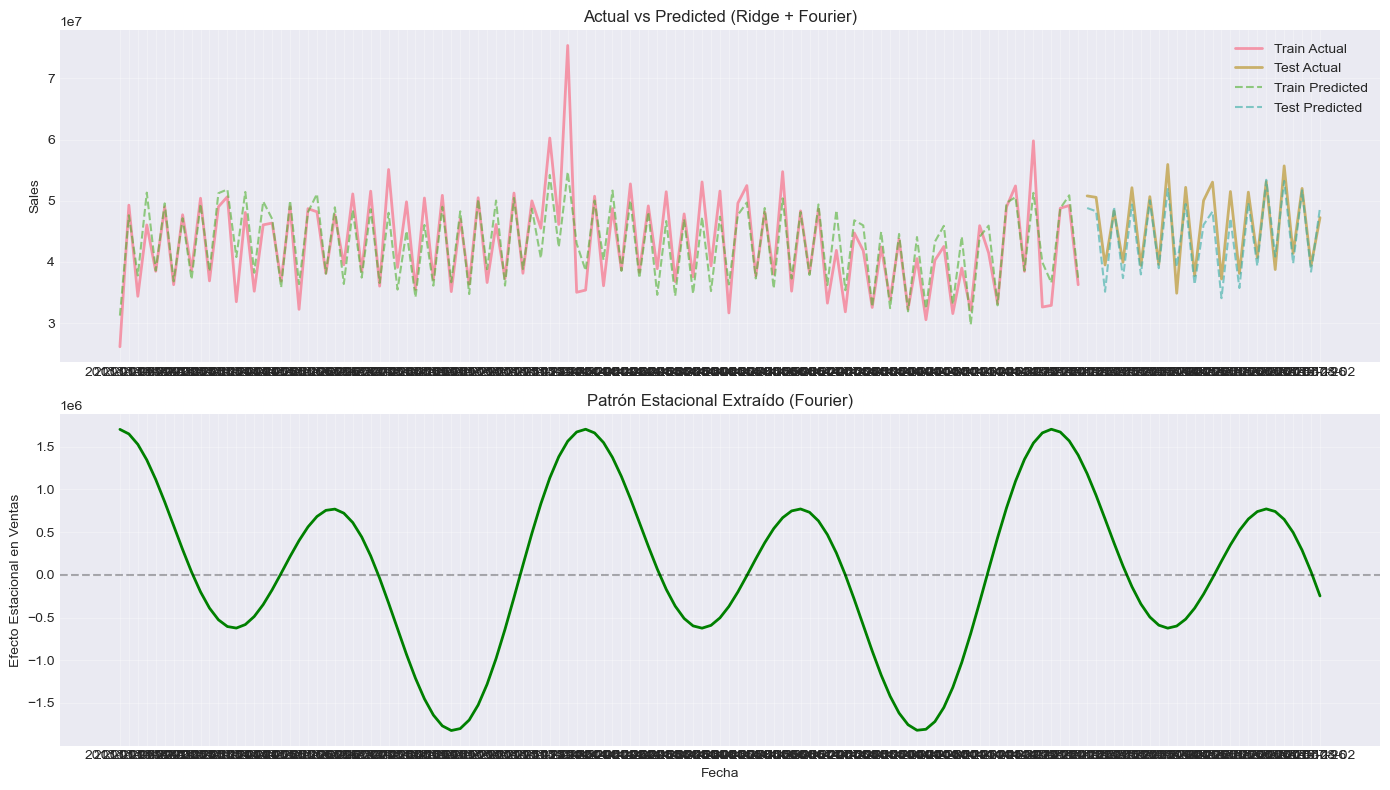

In [16]:
# Visualizar patrón estacional extraído
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Actual vs Predicted
axes[0].plot(dates_f[:split_idx], y_train_f.values,
             label='Train Actual', alpha=0.7, linewidth=2)
axes[0].plot(dates_f[split_idx:], y_test_f.values,
             label='Test Actual', alpha=0.7, linewidth=2)
axes[0].plot(dates_f[:split_idx], y_pred_train_f,
             label='Train Predicted', alpha=0.6, linestyle='--')
axes[0].plot(dates_f[split_idx:], y_pred_test_f,
             label='Test Predicted', alpha=0.6, linestyle='--')
axes[0].legend()
axes[0].set_title('Actual vs Predicted (Ridge + Fourier)')
axes[0].set_ylabel('Sales')
axes[0].grid(alpha=0.3)

# Plot 2: Componente estacional extraído
# Extraer contribución solo de Fourier terms
idx_sin1 = feature_cols_fourier.index('fourier_sin_1')
idx_cos1 = feature_cols_fourier.index('fourier_cos_1')
idx_sin2 = feature_cols_fourier.index('fourier_sin_2')
idx_cos2 = feature_cols_fourier.index('fourier_cos_2')

seasonal_effect = (
    best_model_f.coef_[idx_sin1] * X_f['fourier_sin_1'] +
    best_model_f.coef_[idx_cos1] * X_f['fourier_cos_1'] +
    best_model_f.coef_[idx_sin2] * X_f['fourier_sin_2'] +
    best_model_f.coef_[idx_cos2] * X_f['fourier_cos_2']
)

axes[1].plot(dates_f, seasonal_effect, color='green', linewidth=2)
axes[1].set_title('Patrón Estacional Extraído (Fourier)')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Efecto Estacional en Ventas')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# XGBoost

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist_xgb = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
    'reg_lambda': [1, 5, 10]
}

xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# RandomizedSearchCV más rápido que GridSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20,  # Probar 20 combinaciones
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# NO escalar features para XGBoost (árboles no lo necesitan)
print("Entrenando XGBoost...")
random_search_xgb.fit(X_train_f, y_train_f)

print(f"\nMejores params: {random_search_xgb.best_params_}")
print(f"Mejor R² CV: {random_search_xgb.best_score_:.4f}")


Entrenando XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores params: {'subsample': 1.0, 'reg_lambda': 5, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.01}
Mejor R² CV: 0.5948


In [ ]:
# XGBoost - Evaluación
best_xgb = random_search_xgb.best_estimator_

y_pred_train_xgb = best_xgb.predict(X_train_f)
y_pred_test_xgb = best_xgb.predict(X_test_f)

r2_train_xgb = r2_score(y_train_f, y_pred_train_xgb)
r2_test_xgb = r2_score(y_test_f, y_pred_test_xgb)
gap_xgb = r2_train_xgb - r2_test_xgb

print("=" * 70)
print("XGBoost Performance")
print("=" * 70)
print(f"R² Train: {r2_train_xgb:.4f}")
print(f"R² Test:  {r2_test_xgb:.4f}")
print(f"Gap:      {gap_xgb:.4f}")
print("=" * 70)



XGBoost Performance
R² Train: 0.8991
R² Test:  0.7544
Gap:      0.1446

⚠️  WARNING: Gap > 0.10 indica OVERFITTING
   Considera: reducir max_depth, aumentar reg_lambda

COMPARACIÓN: Ridge+Fourier vs XGBoost
Ridge+Fourier:  R² Test = 0.8439, Gap = -0.0617
XGBoost:        R² Test = 0.7544, Gap = 0.1446
Diferencia:     -0.0894

⚠️  XGBoost NO mejora significativamente → quedarse con Ridge+Fourier
